In [5]:
# pip install numpy --upgrade
# conda install -c conda-forge opencv=3.2.0

In [1]:
import os
import random
import shutil
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from PIL import Image
from imutils import paths 
import numpy as np  
import random
import cv2
import mahotas as mt
import matplotlib.pyplot as plt
import itertools
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
def fd_hu_moments(image):
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [2]:
def extract_features(image):
    textures = mt.features.haralick(image)
    ht_mean= textures.mean(axis = 0)
    return ht_mean

In [3]:
def fd_histogram(image, mask = None):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image],[0,1,2],None, [bins,bins,bins],[0,256,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()

In [5]:
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)
global_feature = []
data = []
labels = []
IMAGE_DIMS = (50,50,1)
bins = 8
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    fv_histogram = fd_histogram(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fv_hu_moments = fd_hu_moments(image)
    features = extract_features(image)
    global_feature = np.hstack([fv_histogram, features, fv_hu_moments])
    data.append(global_feature)
    l = label = imagePath.split(os.path.sep)[-2]
    labels.append(l)

In [7]:
models = {
    "Random Forest Classifier": RandomForestClassifier(n_estimators = 100),
    "Linear Discriminant Anaysis":LinearDiscriminantAnalysis(),
    "Logistic Regression": LogisticRegression(solver="lbfgs", multi_class = "auto"),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors = 1),
    "Quadratic Discriminant Anaysis":QuadraticDiscriminantAnalysis(),
    "Gradient Boosing Classifier": GradientBoostingClassifier(),
}

In [8]:
#Save the data as CSV file
df = pd.DataFrame({'Global Features':data,'Label':labels}).to_csv('malaria_features.csv')
df_file = pd.read_csv('malaria_features.csv')
df_file.head()

,Unnamed: 0,Global Features,Label
0,0,[ 5.61054885e-01 3.31985112e-03 3.31985112e-...,Status_Healthy
1,1,[ 4.20449138e-01 0.00000000e+00 1.72080146e-...,Status_infected
2,2,[ 3.96022499e-01 0.00000000e+00 0.00000000e+...,Status_Healthy
3,3,[ 4.88425672e-01 0.00000000e+00 0.00000000e+...,Status_infected
4,4,[ 4.99253213e-01 0.00000000e+00 0.00000000e+...,Status_infected


In [9]:
(trainData, testData, trainLabels, testLabels) = train_test_split(data,labels,test_size=0.5,random_state=0)

In [10]:
imagePaths = sorted(list(paths.list_images("testdata")))
random.seed(42)
random.shuffle(imagePaths)
datatest = []
labelstest = []
IMAGE_DIMS = (50,50,1)
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(IMAGE_DIMS[1],IMAGE_DIMS[0]))
    fv_histogram = fd_histogram(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    fv_hu_moments = fd_hu_moments(image)
    features = extract_features(image)
    global_feature = np.hstack([fv_histogram,features,fv_hu_moments])
    datatest.append(global_feature)
    labell = imagePath.split(os.path.sep)[-2]
    labelstest.append(labell)

In [11]:
lb2 = LabelEncoder()
labelsll = lb2.fit_transform(labelstest)
print(lb2.classes_)

['Status_Healthy' 'Status_infected']


In [12]:
for m in models:
    print("Using {} model".format(m))
    print("---------------")
    model= models[m]
    model.fit(trainData,trainLabels)
    print("Score for train Data: ", model.score(testData,testLabels))
    print("Score: " , model.score(datatest, labelstest))
    predictionstest = model.predict(datatest)
    print("Confusion matrix:\n " ,confusion_matrix(labelstest,predictionstest))
    print("Classification report:\n ", classification_report(labelstest, predictionstest))
    pred_proba = model.predict_proba(datatest) 
    auc_score = roc_auc_score(labelsll, pred_proba[::,1])
    print("AUC Score: ", auc_score)

Using Random Forest Classifier model
---------------------
Score for train Data:  0.9577648766328012
Score:  0.9573263662094491
Confusion matrix:
  [[6623  267]
 [ 321 6568]]
Classification report:
                   precision    recall  f1-score   support

 Status_Healthy       0.95      0.96      0.96      6890
Status_infected       0.96      0.95      0.96      6889

       accuracy                           0.96     13779
      macro avg       0.96      0.96      0.96     13779
   weighted avg       0.96      0.96      0.96     13779

AUC Score:  0.988997720646343
Using Decision Tree Classifier model
---------------------
Score for train Data:  0.9298984034833091
Score:  0.930111038536904
Confusion matrix:
  [[6442  448]
 [ 515 6374]]
Classification report:
                   precision    recall  f1-score   support

 Status_Healthy       0.93      0.93      0.93      6890
Status_infected       0.93      0.93      0.93      6889

       accuracy                           0.93     13

/home/fani/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Score for train Data:  0.8336719883889695
Score:  0.8311923942230931
Confusion matrix:
  [[6704  186]
 [2140 4749]]
Classification report:
                   precision    recall  f1-score   support

 Status_Healthy       0.76      0.97      0.85      6890
Status_infected       0.96      0.69      0.80      6889

       accuracy                           0.83     13779
      macro avg       0.86      0.83      0.83     13779
   weighted avg       0.86      0.83      0.83     13779

AUC Score:  0.9083819180406028
Using Gradient Boosing Classifier model
---------------------
Score for train Data:  0.9557329462989841
Score:  0.956020030481167
Confusion matrix:
  [[6659  231]
 [ 375 6514]]
Classification report:
                   precision    recall  f1-score   support

 Status_Healthy       0.95      0.97      0.96      6890
Status_infected       0.97      0.95      0.96      6889

       accuracy                           0.96     13779
      macro avg       0.96      0.96      0.96     

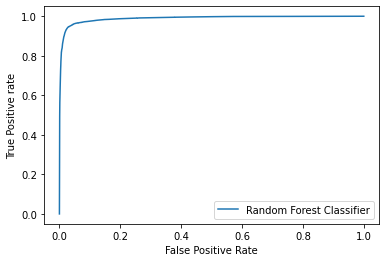

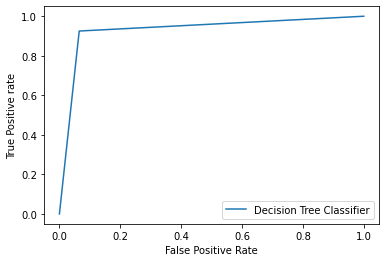

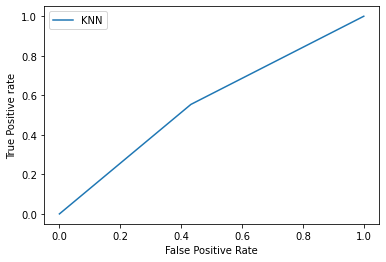

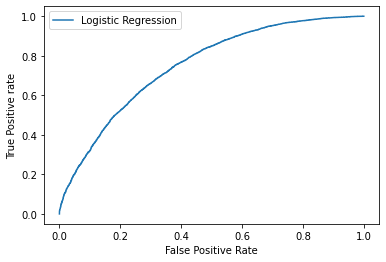

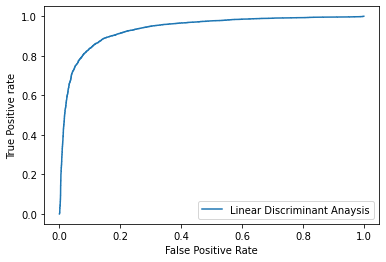

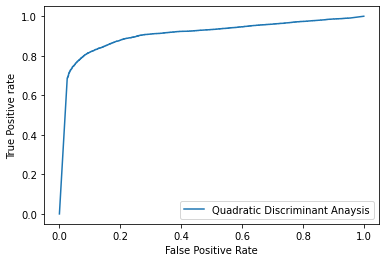

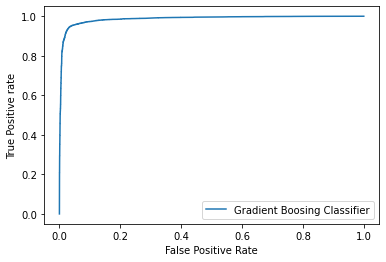

In [13]:
for m in models:
    model = models[m] 
    proba = model.predict_proba(datatest) 
    fpr, tpr, _ = roc_curve(labelsll, proba[::,1], pos_label=1)
    plt.plot(fpr, tpr, linestyle='-', label=m)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.show()

In [10]:
print("What I would choose as a final model is Random Forest Model, because it has a better AUC score than the other models.")

What I would choose as a final model is Random Forest Model, because it has a better AUC score than the other models.
